#### **DATASET:** https://zenodo.org/records/3384388 (Mimii Pump)

### **Imports**

In [1]:
import librosa
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                             confusion_matrix, precision_recall_curve)
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.linear_model import SGDOneClassSVM
from sklearn.svm import OneClassSVM
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, Adamax, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
from utils import (split_audio_files, load_audios, extract_mfccs, extract_spectral_features, extract_temporal_features,
                   get_anomaly_treshold, model_evaluate)
from models import AutoEncoder

In [75]:
#plt.style.use('fivethirtyeight')
#plt.style.available
%matplotlib inline

### **A. Load Audio Files:**

- give directory of abnormal and normal wav files

In [3]:
normal_path = 'audio_dataset/mimii-sound/pump/normal/' # 381 normal audios (each 10 sec .wav)
abnormal_path = 'audio_dataset/mimii-sound/pump/abnormal/' # 138 abnormal audios (each 10 sec .wav)

In [4]:
x2_normal_path = 'audio_dataset/mimii-sound/pump/normal_x2/' # 762 normal audios (each 5 sec .wav)
x2_abnormal_path = 'audio_dataset/mimii-sound/pump/abnormal_x2/' # 274 abnormal audios (each 5 sec .wav)

- split each audio file in a given input directory into two halves

In [78]:
# split_audio_files(normal_path, x2_normal_path)
# split_audio_files(abnormal_path, x2_abnormal_path)

- read and load .wav files

In [5]:
normal_audios, normal_labels, sample_rate, normal_file_names = load_audios(x2_normal_path, label=0) 
abnormal_audios, abnormal_labels, _, abnormal_file_names = load_audios(x2_abnormal_path, label=1) 
print(normal_audios[0][:15]) # first normal audio's first 15 samples
print(abnormal_audios[0][:15]) # first abnormal audio's first 15 samples
print('Sample Rate:', sample_rate)

[-0.00039673 -0.00158691 -0.0020752  -0.00167847 -0.00097656 -0.00149536
 -0.00134277 -0.00241089 -0.00228882 -0.00064087 -0.00088501 -0.00204468
 -0.00274658 -0.00241089 -0.00189209]
[ 2.7465820e-04 -2.1362305e-03 -6.1950684e-03 -7.2021484e-03
 -5.6762695e-03 -6.5917969e-03 -5.6762695e-03 -5.0964355e-03
 -5.1269531e-03 -3.6926270e-03 -8.8500977e-04 -1.1901855e-03
 -6.1035156e-05 -1.4038086e-03  7.3242188e-04]
Sample Rate: 16000


- randomly pick a sample audio from both class

In [80]:
normal_audio = normal_audios[random.randint(0, len(normal_audios) - 1)]
abnormal_audio = abnormal_audios[random.randint(0, len(abnormal_audios) - 1)]

- listen random samples from **normal** and **abnormal** audios

In [81]:
print('Normal Class Sample: ')
ipd.display(ipd.Audio(normal_audio, rate=sample_rate))

Normal Class Sample: 


In [82]:
print('Abnormal Class Sample: ')
ipd.display(ipd.Audio(abnormal_audio, rate=sample_rate))

Abnormal Class Sample: 


### **B. Explore Waveforms:**

- Display **normal** and **abnormal** waveforms

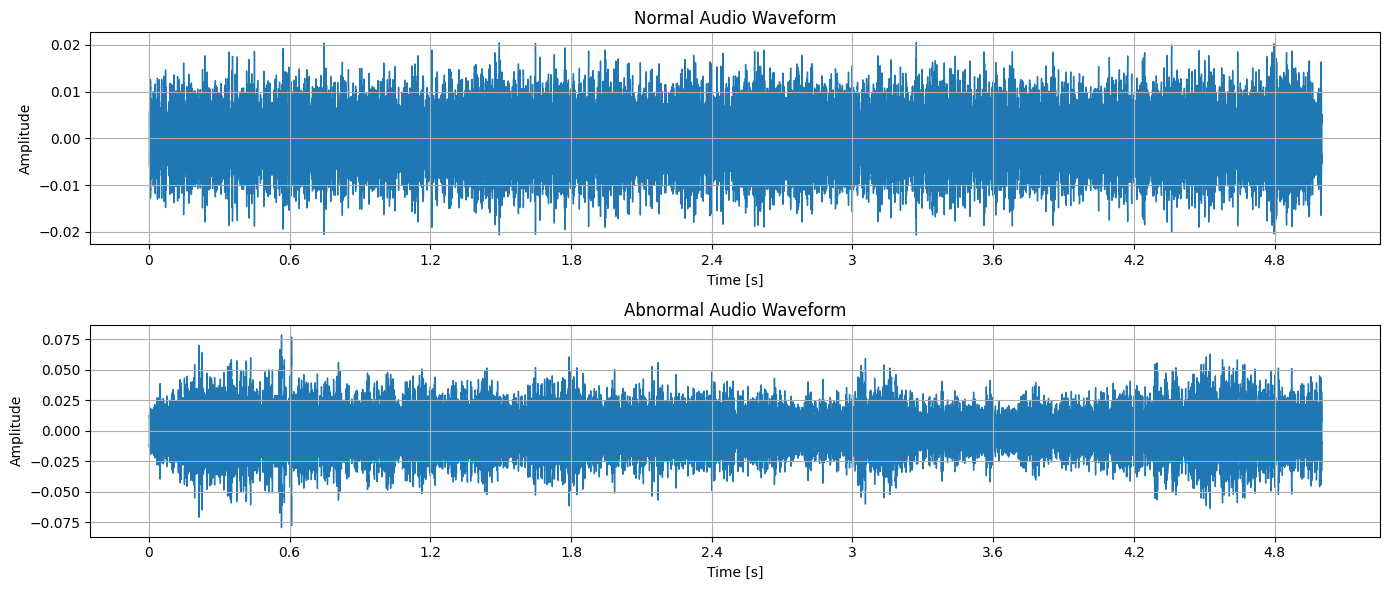

In [83]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
librosa.display.waveshow(normal_audio, sr=sample_rate)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title('Normal Audio Waveform')
plt.grid()

plt.subplot(2, 1, 2)
librosa.display.waveshow(abnormal_audio, sr=sample_rate)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title('Abnormal Audio Waveform')

plt.grid()
plt.tight_layout()
plt.show()

- Display **normal** and **abnormal** spectrum *(fourier transform)*

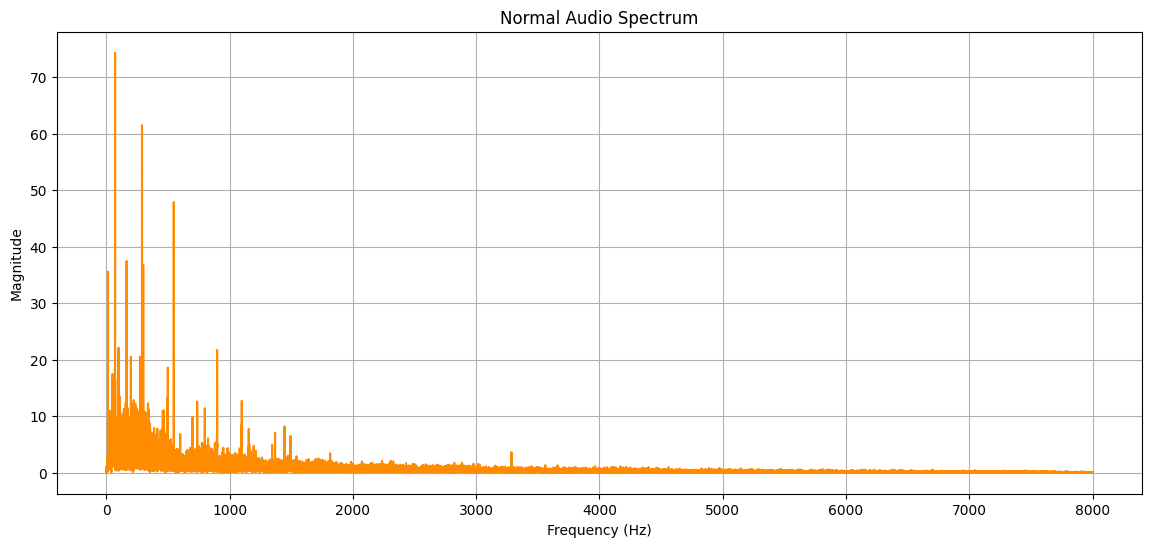

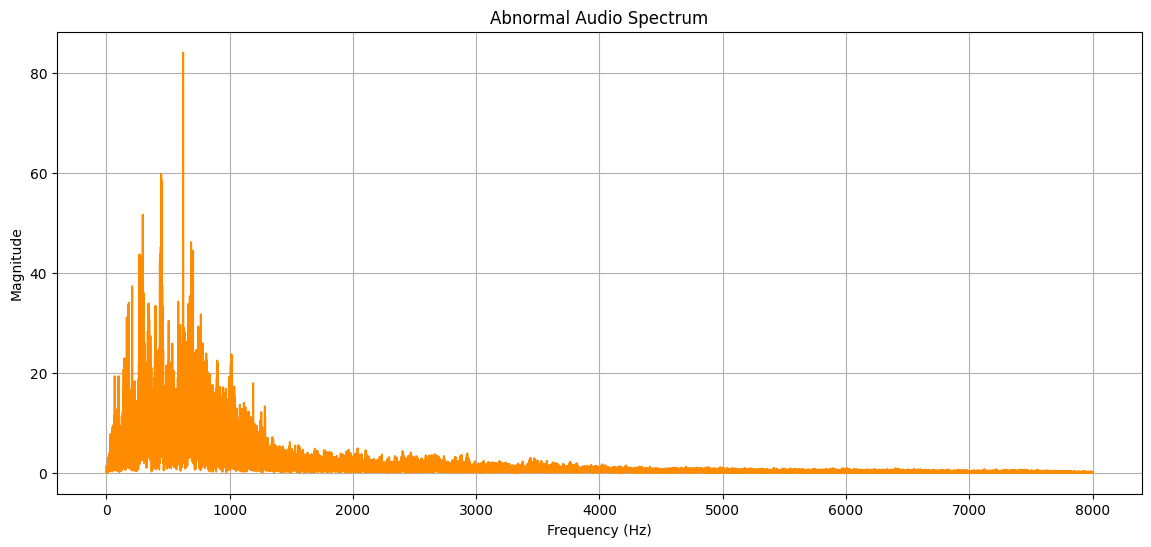

In [84]:
def plot_spectrum(audio, sample_rate, title):
    # Fourier Transform 
    fft_result = np.fft.fft(audio)
    fft_magnitude = np.abs(fft_result)
    freq = np.fft.fftfreq(len(fft_result), 1/sample_rate)

    plt.figure(figsize=(14, 6))
    plt.plot(freq[:len(freq)//2], fft_magnitude[:len(freq)//2], color='darkorange')  # Only plot the positive frequencies
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude')
    plt.title(title)
    plt.grid()
    plt.show()
plot_spectrum(normal_audio, sample_rate, 'Normal Audio Spectrum')
plot_spectrum(abnormal_audio, sample_rate, 'Abnormal Audio Spectrum')

- Display Spectograms of **normal** and **abnormal** waveforms

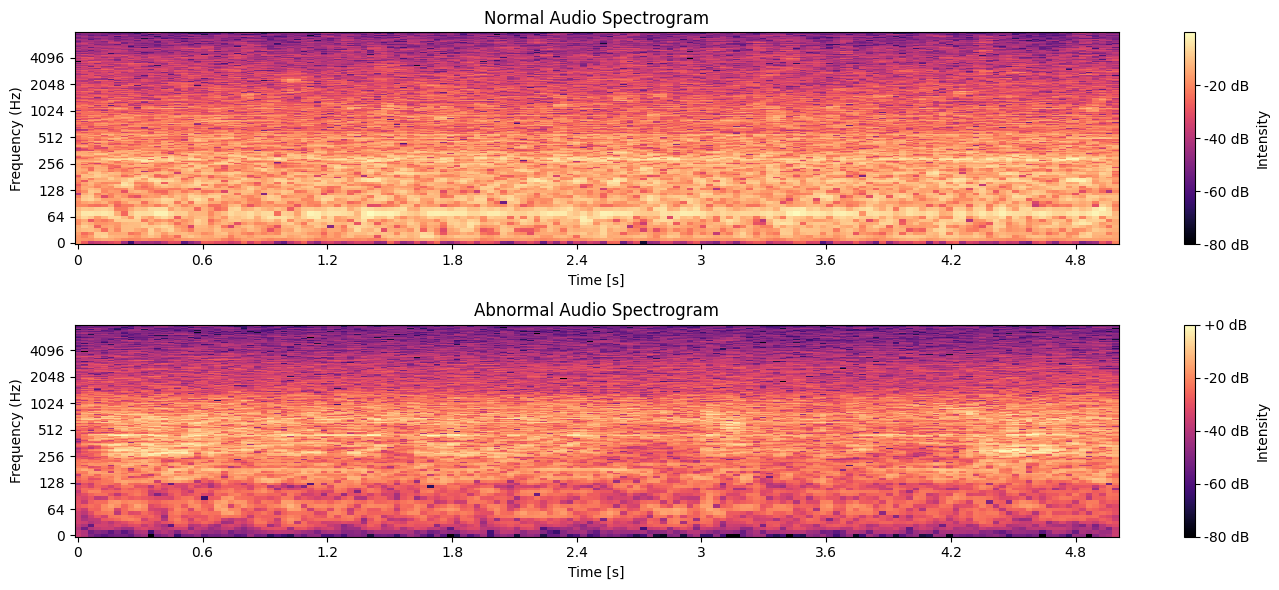

In [85]:
plt.figure(figsize=(14, 6))

plt.subplot(2, 1, 1)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(normal_audio)), ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(label = 'Intensity', format='%+2.f dB')
plt.xlabel("Time [s]")
plt.ylabel("Frequency (Hz)")
plt.title('Normal Audio Spectrogram')

plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(abnormal_audio)), ref=np.max), sr=sample_rate, x_axis='time', y_axis='log')
plt.colorbar(label = 'Intensity', format='%+2.f dB')
plt.xlabel("Time [s]")
plt.ylabel("Frequency (Hz)")
plt.title('Abnormal Audio Spectrogram')

plt.tight_layout()
plt.show()

### **C. Audio Feature Extractions**
- Mel-Frequency Cepstral Coefficients (MFCC)
- Chroma Features?
- Spectral Features
    - spectral_centroid
    - spectral_rolloff
    - spectral_contrast
- Temporal Features
    - zero_crossing_rate
    - autocorrelate
- Data Augmentation 
    - time shifting
    - adding noise

- #### **Mel-Frequency Cepstral Coefficients (MFCC):**
    - **The mel-frequency cepstrum (MFC)** is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.

In [86]:
N_MFCC = 13
print('Normal Audio mel-frequency cepstrum coefficients:\n', extract_mfccs(normal_audio, sample_rate, N_MFCC))
print('\nAbnormal Audio mel-frequency cepstrum coefficients:\n', extract_mfccs(abnormal_audio, sample_rate, N_MFCC))

Normal Audio mel-frequency cepstrum coefficients:
 [-3.4959109e+02  1.0400183e+02  1.5099193e-01  2.1026772e+01
 -4.9566373e-01  1.1102342e+01  6.3956445e-01  3.3876128e+00
 -2.7081556e+00 -1.0114499e-02 -2.9387360e+00 -3.5335457e-01
 -4.9497554e-01]

Abnormal Audio mel-frequency cepstrum coefficients:
 [-266.63196    121.58957    -18.003538    -3.8243315  -25.999971
   -8.355871    -2.724443    -2.705454    -7.4838476   -2.9735198
   -4.393131    -1.4593135   -5.833094 ]


- #### **Spectral Features:**
    - The **spectral centroid** is a measure used in digital signal processing to characterise a spectrum. It indicates where the center of mass of the spectrum is located. Perceptually, it has a robust connection with the impression of brightness of a sound.
    
    - The **Spectral rolloff** is the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies.

In [87]:
print('Normal Audio Spectral Features:\n', extract_spectral_features(normal_audio, sample_rate))
print('\nAbnormal Audio Spectral Features:\n', extract_spectral_features(abnormal_audio, sample_rate))

Normal Audio Spectral Features:
 (1570.7678883089043, 3498.8057324840765, 16.702497272357917, 0.031240767)

Abnormal Audio Spectral Features:
 (1393.3514891910804, 2679.8367834394903, 21.71005927101307, 0.0043347045)


- #### **Temporal Features:**
    - **The zero-crossing rate (ZCR)** is the rate at which a signal changes from positive to zero to negative or from negative to zero to positive
    
    - **The autocorrelation**, sometimes known as serial correlation in the discrete time case, is the correlation of a signal with a delayed copy of itself as a function of delay. Informally, it is the similarity between observations of a random variable as a function of the time lag between them

In [88]:
print('Normal Audio Temporal Features:\n', extract_temporal_features(normal_audio))
print('\nAbnormal Audio Temporal Features:\n', extract_temporal_features(abnormal_audio))

Normal Audio Temporal Features:
 (0.09587728901273886, 2.0548685081303106e-05)

Abnormal Audio Temporal Features:
 (0.1009031648089172, 0.00011732865956146293)


- #### **Combine Selected Features:**

In [89]:
def combine_feature_extractions(audio_data, sample_rate):
    """
    Combine all the features here.
    """
    features = []
    for audio in audio_data:
        mfccs = extract_mfccs(audio, sample_rate)
        spectral_features = extract_spectral_features(audio, sample_rate)
        temporal_features = extract_temporal_features(audio)
        all_features = np.concatenate([mfccs, spectral_features, temporal_features], axis=0)
        features.append(all_features)
    return np.array(features)

normal_features = combine_feature_extractions(normal_audios, sample_rate)
abnormal_features = combine_feature_extractions(abnormal_audios, sample_rate)    

In [90]:
print(normal_features.shape, type(normal_features))
print(abnormal_features.shape, type(abnormal_features))

(762, 19) <class 'numpy.ndarray'>
(276, 19) <class 'numpy.ndarray'>


- #### **Construct a Clean Dataframe:**

In [91]:
mfcc_names = [f'MFCC{ix}' for ix in range(1,N_MFCC+1)]
spectral_names = ['Spectral Centroid', 'Spectral Rolloff', 'Spectral Contrast', 'Spectral Melspectrogram']
temporal_names = ['Zero Crossing Rate', 'Autocorrelation']
all_feature_names = mfcc_names + spectral_names + temporal_names

normal_df = pd.DataFrame(normal_features, columns=all_feature_names)
normal_df['labels'] = normal_labels
normal_df['file_names'] = normal_file_names
abnormal_df = pd.DataFrame(abnormal_features, columns=all_feature_names)
abnormal_df['labels'] = abnormal_labels
abnormal_df['file_names'] = abnormal_file_names
df = pd.concat([normal_df, abnormal_df]).reset_index(drop=True)

- download final df for further analysis and vizualizations

In [92]:
# df.to_csv("audio_final_df_x2.csv")

### **D. Data Augmentation:** 
Apply data augmentation to training data to help model to generalize. (maybe later)
- Noise Adding
- Time Shifting
- Pitch Scaling
- Gain Scaling

### **E. Prepare Data for Model Training and Testing:**

- **Training Data:** *%80 normal* 
- **Validation Data:** *%10 normal*
- **Test Data:** *%10 normal + %100 abnormal*

In [116]:
scaler = StandardScaler()
X_train, X_val, _, y_val = train_test_split(normal_features, normal_labels, test_size=0.2, random_state=10)
X_val1, X_val2, y_val1, y_val2 = train_test_split(X_val, y_val, test_size=0.5, random_state=10)
X_test = abnormal_features

X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled1 = scaler.transform(X_val1)
X_val_scaled2 = scaler.transform(X_val2)
X_test_scaled = scaler.transform(X_test)

train_data = X_train_scaled # %80 of normal
validation_data = X_val_scaled1 # %10 of normal
test_data = np.concatenate((X_val_scaled2, X_test_scaled))  # %10 of normal + % 100 of abnormal
test_label = np.concatenate((y_val2, np.array(abnormal_labels)))

In [94]:
print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)
print(test_label.shape)

(609, 19)
(76, 19)
(353, 19)
(353,)


### **F. Models**
- **Deep Learning Models:**
    1. AutoEncoders (AE) **[DONE]**
    2. Variational AutoEncoders (VAE)
    3. LSTM AutoEncoders (LSTMAE)
    4. Convolutional AutoEncoders (CAE) 
- **Machine Learning Models:**
    1. One Class Support Vector Machine (OCSVM) **[DONE]**
    2. SGD One Class Support Vector Machine (SGD OCSV) **[DONE]**
    3. Isolation Forest (IF) **[DONE]**
    4. Locale Outlier Factor (LOF) **[DONE]**

### **Deep Learning Models:**

#### **1. AutoEncoder (AE)** 

In [95]:
def AutoEncoder(input_dimension):
    # Deep AutoEncoder 
    input_layer = Input(shape=(input_dimension,))

    encoder = Dense(128, activation='relu')(input_layer)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(64, activation='relu')(encoder)
    encoder = BatchNormalization()(encoder)
    encoder = Dropout(0.1)(encoder)
    encoder = Dense(32, activation='relu')(encoder)

    decoder = Dense(64, activation='relu')(encoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    decoder = Dense(128, activation='relu')(decoder)
    decoder = BatchNormalization()(decoder)
    decoder = Dropout(0.1)(decoder)
    output_layer = Dense(input_dimension, activation='sigmoid')(decoder)
    
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer=Adamax(learning_rate=0.0005), loss='mean_squared_error')
    return autoencoder

- Model Summary

In [96]:
input_dim = train_data.shape[1]
ae = AutoEncoder(input_dim)
ae.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 19)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │         2,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 19)             │         2,451 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,315 (106.70 KB)

 Trainable params: 26,547 (103.70 KB)

 Non-trainable params: 768 (3.00 KB)

In [97]:
def model_training(X_train, X_val):
    input_dim = X_train.shape[1]
    autoencoder = AutoEncoder(input_dim)

    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=5, 
                                   restore_best_weights=True, 
                                   verbose=True)
    autoencoder.fit(
                    X_train, X_train,
                    epochs=400, 
                    batch_size=180, # 256
                    shuffle=True,
                    validation_data=(X_val, X_val),
                    callbacks=[early_stopping],
                    verbose=1
                    )
    return autoencoder

In [98]:
def model_prediction(autoencoder, X_test, y_test):
    reconstructed_input = autoencoder.predict(X_test)
    reconstruction_error = np.mean(np.square((X_test - reconstructed_input)), axis=1)
    optimal_threshold = get_anomaly_treshold(reconstruction_error, y_test)
    predictions = (reconstruction_error > optimal_threshold).astype(int)
    return predictions, optimal_threshold

In [99]:
autoencoder = model_training(train_data, validation_data)
ae_predictions, threshold = model_prediction(autoencoder, test_data, test_label)

Epoch 1/400


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.3544 - val_loss: 1.4568
Epoch 2/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2803 - val_loss: 1.4484
Epoch 3/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2217 - val_loss: 1.4402
Epoch 4/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2198 - val_loss: 1.4325
Epoch 5/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1816 - val_loss: 1.4246
Epoch 6/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1771 - val_loss: 1.4168
Epoch 7/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1273 - val_loss: 1.4091
Epoch 8/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0893 - val_loss: 1.4012
Epoch 9/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1154 - val_loss: 1.3929
Epoch 10/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0799 - val_loss: 1.3843
Epoch 11/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0639 - val_loss: 1.3754
Epoch 12/400
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0512 - val_loss: 1.3662
Epoch 13/400

In [100]:
# print(ae_predictions)

In [101]:
model_evaluate(ae_predictions, test_label, threshold)

Optimal Threshold: 0.8389783416536405

Accuracy: 0.9320113314447592
Precision: 0.9532374100719424
Recall: 0.9601449275362319
F1 Score: 0.9566787003610109


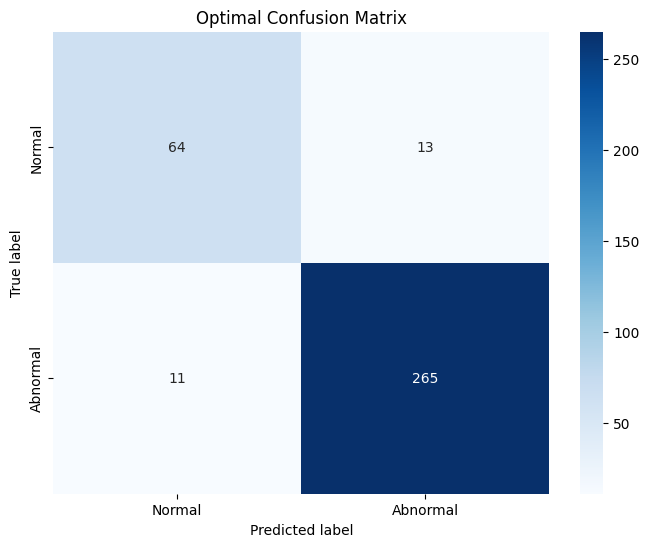

In [102]:
optimal_cm = confusion_matrix(test_label, ae_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Optimal Confusion Matrix')
plt.show()

In [103]:
# autoencoder.save('AutoEncoderModel_v1.keras')

### **Machine Learning Models:**

#### **1. OneClass Support Vector Machine**

In [104]:
# ocsvm = OneClassSVM(kernel='rbf',
#                     gamma='scale').fit(train_data)
# ocsvm_predictions = ocsvm.predict(test_data)
# ocsvm_predictions = np.where(ocsvm_predictions == -1, 1, 0)

In [105]:
ocsvm = OneClassSVM(kernel='rbf',
                    gamma='scale').fit(train_data)
anomaly_scores = ocsvm.decision_function(test_data)
optimal_threshold = get_anomaly_treshold(-anomaly_scores, test_label)
ocsvm_predictions = (anomaly_scores < -optimal_threshold).astype(int)

In [106]:
model_evaluate(ocsvm_predictions, test_label)

Accuracy: 0.9461756373937678
Precision: 0.9508771929824561
Recall: 0.9818840579710145
F1 Score: 0.966131907308378


#### **2. SGD OneClass Support Vector Machine**

In [107]:
SGD_ocsvm= SGDOneClassSVM(random_state=10,
                          shuffle=True,
                          fit_intercept=False).fit(train_data)
SGD_ocsvm_predictions = SGD_ocsvm.predict(test_data)
SGD_ocsvm_predictions = np.where(SGD_ocsvm_predictions == -1, 1, 0)

In [108]:
model_evaluate(SGD_ocsvm_predictions, test_label)

Accuracy: 0.40793201133144474
Precision: 0.7375886524822695
Recall: 0.37681159420289856
F1 Score: 0.49880095923261386


#### **3. Isolation Forest (IF)** 

- Data distributions for isolation forest models. (train_data includes anomalies.)

In [120]:
normal80, normal20, _, y_normal20 = train_test_split(normal_features, normal_labels, test_size=0.2, random_state=10)
abnormal60, abnormal40, _, y_abnormal40 = train_test_split(abnormal_features, abnormal_labels, test_size=0.4, random_state=10)

normal80x = scaler.fit_transform(normal80)
abnormal60x = scaler.transform(abnormal60)
normal20x = scaler.transform(normal20)
abnormal40x = scaler.transform(abnormal40)

train_data = np.concatenate((normal80x, abnormal60x))
test_data = np.concatenate((normal20x, abnormal40x))
test_label = np.concatenate((y_normal20, y_abnormal40))

contamination_percentage = len(abnormal60x) / (len(normal80x) + len(abnormal60x))
contamination_percentage

0.2131782945736434

In [118]:
iso_forest = IsolationForest(random_state=10).fit(train_data)

anomaly_scores = iso_forest.decision_function(test_data)
optimal_threshold = get_anomaly_treshold(-anomaly_scores, test_label)
if_predictions = (anomaly_scores < -optimal_threshold).astype(int)

In [111]:
# isolation_forest = IsolationForest(n_estimators=120,
#                                    contamination=contamination_percentage,
#                                    random_state=10).fit(train_data)
# if_predictions = isolation_forest.predict(test_data)
# if_predictions = np.where(if_predictions == -1, 1, 0)

In [119]:
model_evaluate(if_predictions, test_label)

Accuracy: 0.7348484848484849
Precision: 0.6273291925465838
Recall: 0.9099099099099099
F1 Score: 0.7426470588235293


#### **4. Locael Outlier Factor (LOF)**

In [113]:
# lof = LocalOutlierFactor(algorithm='auto',
#                          n_neighbors=150,
#                          contamination=contamination_percentage, 
#                          novelty=True).fit(train_data)
# lof_predictions = lof.predict(test_data)
# lof_predictions = np.where(lof_predictions == -1, 1, 0)

In [121]:
lof = LocalOutlierFactor(n_neighbors=150,
                         contamination=contamination_percentage, 
                         novelty=True).fit(train_data)
anomaly_scores = lof.decision_function(test_data)
optimal_threshold = get_anomaly_treshold(-anomaly_scores, test_label)
lof_predictions = (anomaly_scores < -optimal_threshold).astype(int)

In [122]:
model_evaluate(lof_predictions, test_label)

Accuracy: 0.9015151515151515
Precision: 0.9292929292929293
Recall: 0.8288288288288288
F1 Score: 0.8761904761904762
